# Used Car Price Analysis (CRISP-DM)


## 0. Setup

In [15]:

import os, sys, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

RANDOM_STATE = 42
sns.set(style="whitegrid")
pd.set_option("display.max_columns", 100)


## 1. Business Understanding
Goal: Identify which features most drive used car prices and produce actionable guidance for a dealership (buying, reconditioning, listing).

## 2. Data Understanding & Loading

In [16]:
CSV_PATH = "/content/sample_data/vehicles.csv"

df = pd.read_csv(CSV_PATH)
print(df.shape)
df.head()

(426880, 18)


,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


### 2.1 Quick EDA

In [17]:
# Basic info
display(df.describe(include='all').transpose())
df.isna().mean().sort_values(ascending=False).head(20)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,426880.0,NaN,NaN,NaN,7311486634.224333,4473170.412559,7207408119.0,7308143339.25,7312620821.0,7315253543.5,7317101084.0
region,426880,404,columbus,3608,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,426880.0,NaN,NaN,NaN,75199.033187,12182282.173604,0.0,5900.0,13950.0,26485.75,3736928711.0
year,425675.0,NaN,NaN,NaN,2011.235191,9.45212,1900.0,2008.0,2013.0,2017.0,2022.0
manufacturer,409234,42,ford,70985,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model,421603,29649,f-150,8009,NaN,NaN,NaN,NaN,NaN,NaN,NaN
condition,252776,6,good,121456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cylinders,249202,8,6 cylinders,94169,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fuel,423867,5,gas,356209,NaN,NaN,NaN,NaN,NaN,NaN,NaN
odometer,422480.0,NaN,NaN,NaN,98043.331443,213881.500798,0.0,37704.0,85548.0,133542.5,10000000.0


,0
size,0.717675
cylinders,0.416225
condition,0.407852
VIN,0.377254
drive,0.305863
paint_color,0.305011
type,0.217527
manufacturer,0.041337
title_status,0.019308
model,0.012362


## 3. Visualizations

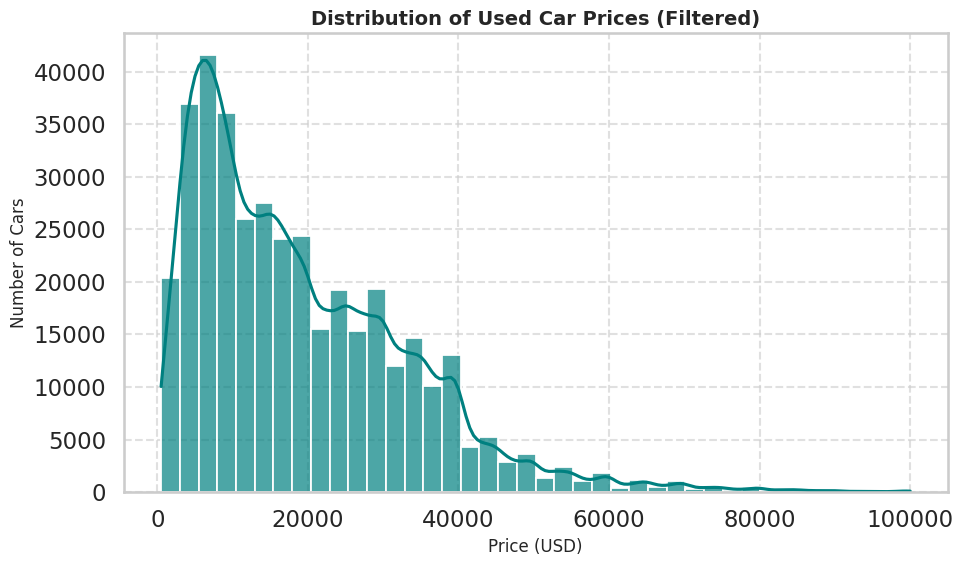

In [18]:
# Set style for clarity
sns.set(style="whitegrid", palette="Set2", context="talk")

# Filter out unrealistic prices (only cars between $500 and $100,000)
filtered_prices = df[df['price'].between(500, 100000)]['price']

# Create the histogram
plt.figure(figsize=(10, 6))
sns.histplot(filtered_prices, bins=40, kde=True, color='teal', alpha=0.7)

# Formatting and labels
plt.title('Distribution of Used Car Prices (Filtered)', fontsize=14, fontweight='bold')
plt.xlabel('Price (USD)', fontsize=12)
plt.ylabel('Number of Cars', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

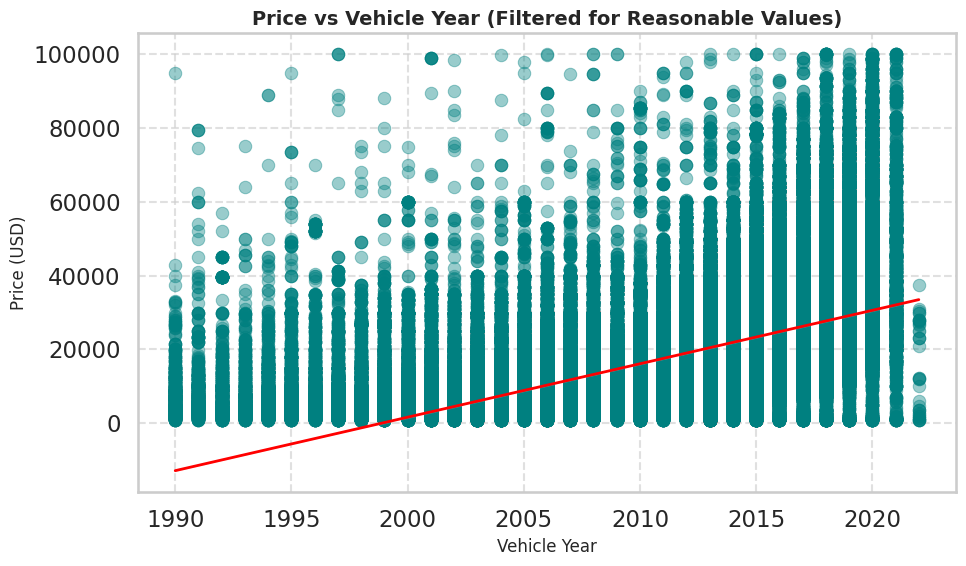

In [19]:
# Price vs Year (Filtered for Reasonable Values)
plt.figure(figsize=(10, 6))

# Keep only realistic values
filtered_df = df[
    (df['price'].between(1000, 100000)) &   # keep only realistic car prices
    (df['year'].between(1990, 2024))        # focus on modern vehicles
]

# Create the scatterplot
sns.scatterplot(data=filtered_df, x='year', y='price', alpha=0.4, color='teal', edgecolor=None)

# Add a trend line
sns.regplot(data=filtered_df, x='year', y='price', scatter=False, color='red', line_kws={'linewidth': 2})

# Formatting
plt.title('Price vs Vehicle Year (Filtered for Reasonable Values)', fontsize=14, fontweight='bold')
plt.xlabel('Vehicle Year', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

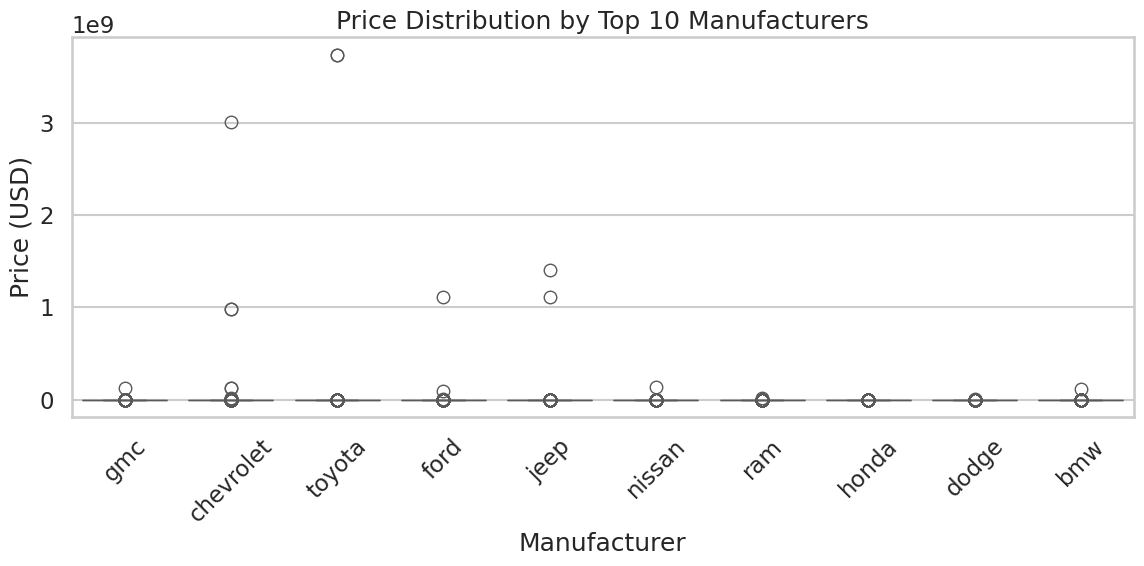

In [20]:
# Price by Manufacturer (Top 10)
top_makes = df['manufacturer'].value_counts().head(10).index
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[df['manufacturer'].isin(top_makes)],
            x='manufacturer', y='price')
plt.title('Price Distribution by Top 10 Manufacturers')
plt.xticks(rotation=45)
plt.xlabel('Manufacturer')
plt.ylabel('Price (USD)')
plt.tight_layout()
plt.show()

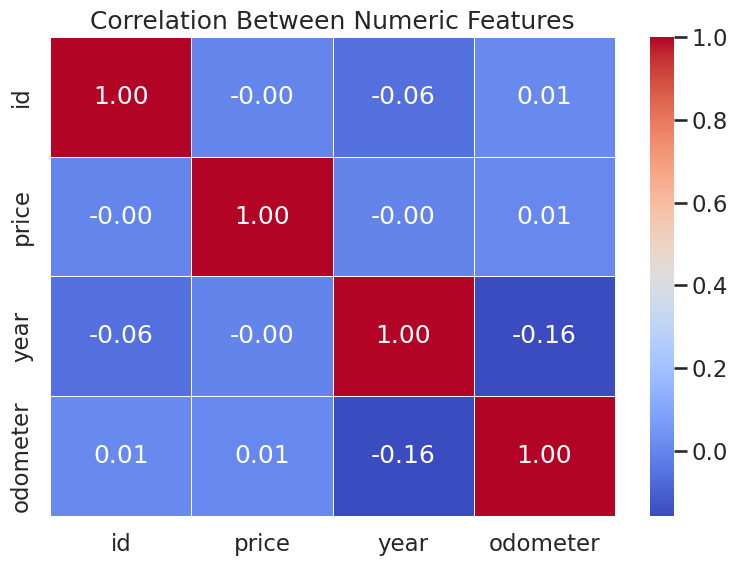

In [21]:
# Correlation Heatmap (Numeric Features)
plt.figure(figsize=(8, 6))
corr = df.select_dtypes(include=['number']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Between Numeric Features')
plt.tight_layout()
plt.show()

## 4. Data Preparation

In [22]:
# Example feature engineering
from datetime import datetime
from sklearn.impute import SimpleImputer

CURRENT_YEAR = datetime.now().year

if 'year' in df.columns:
    df['age'] = np.maximum(0, CURRENT_YEAR - df['year'])
if 'mileage' in df.columns and 'age' in df.columns:
    df['miles_per_year'] = df['mileage'] / np.maximum(1, df['age'])

# Clean price and basic winsorization
df = df[df['price'] > 0].copy()
low, high = df['price'].quantile([0.01, 0.99])
df['price'] = df['price'].clip(lower=low, upper=high)

target = 'price'
features = [c for c in df.columns if c != target]

numeric_features = [c for c in features if pd.api.types.is_numeric_dtype(df[c])]
categorical_features = [c for c in features if c not in numeric_features]

preprocess = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
len(X_train), len(X_test)

(315188, 78797)

## 5. Modeling (with Cross-Validation)

In [23]:
def evaluate(model, X_tr, X_te, y_tr, y_te, name='model'):
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)
    mse = mean_squared_error(y_te, preds) # Calculate MSE
    rmse = np.sqrt(mse) # Calculate RMSE
    mae = mean_absolute_error(y_te, preds)
    r2 = r2_score(y_te, preds)
    print(f"{name}: RMSE={rmse:.2f}, MAE={mae:.2f}, R2={r2:.3f}")
    return rmse, mae, r2

In [24]:
# Linear Regression
lin_pipe = Pipeline(steps=[('prep', preprocess),
                          ('model', LinearRegression())])
evaluate(lin_pipe, X_train, X_test, y_train, y_test, name='Linear')

Linear: RMSE=14061.30, MAE=11170.87, R2=0.036


(np.float64(14061.298415976471), 11170.87213348539, 0.036138558421817235)

In [25]:
# Ridge (grid search)
ridge_pipe = Pipeline(steps=[('prep', preprocess),
                            ('model', Ridge())])
ridge_grid = GridSearchCV(ridge_pipe, param_grid={'model__alpha':[0.1,1,3,10]}, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
ridge_grid.fit(X_train, y_train)
evaluate(ridge_grid.best_estimator_, X_train, X_test, y_train, y_test, name=f'Ridge (alpha={ridge_grid.best_params_["model__alpha"]})')


Ridge (alpha=0.1): RMSE=14061.30, MAE=11170.87, R2=0.036


(np.float64(14061.298415976466), 11170.872133485425, 0.03613855842181812)

In [ ]:
# Random Forest (grid search)
rf_pipe = Pipeline(steps=[('prep', preprocess),
                         ('model', RandomForestRegressor(random_state=RANDOM_STATE))])
rf_params = {'model__n_estimators':[200,400],
             'model__max_depth':[8,12,None]}
rf_grid = GridSearchCV(rf_pipe, param_grid=rf_params, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
rf_grid.fit(X_train, y_train)
evaluate(rf_grid.best_estimator_, X_train, X_test, y_train, y_test, name='RandomForest (best)')

### 5.1 Feature Importance (Random Forest)

In [ ]:
best_rf = rf_grid.best_estimator_
# Extract feature names after preprocessing
ohe = best_rf.named_steps['prep'].transformers_[1][1]
cat_names = list(ohe.get_feature_names_out(categorical_features)) if len(categorical_features)>0 else []
final_feature_names = numeric_features + cat_names

# Get importances
importances = best_rf.named_steps['model'].feature_importances_
fi = pd.DataFrame({'feature': final_feature_names, 'importance': importances}).sort_values('importance', ascending=False).head(20)
fi
